To make the following section clear, we reiterate a few key aspects of Differential Privacy (the application of the Composition and consider the release of queries with correlated error; chapter 4 of Dwork et al.).

Consider the situation in which two elements of an output vector are perturbed almost identically by a change in the data (between $D$ and $D'$).

To mask this sensitivity with simple standard DP, using the Gaussian-mechanism, we add two samples of gaussian noise. To acheive $(\varepsilon, \delta)$-DP overall, we would need independent applications of noise for the two variables using $(\frac{1}{2} \varepsilon, \frac{1}{2} \delta)$-DP for each. This would mean doubling the standard deviation of the noise added to each.

Because they are highly correlated, we do not need to add a completely new sample, but instead can almost add the same noise sample. Because finding the mean of the two results will not help someone infer their value, we can save our $\varepsilon$.

It becomes clear that the noise that we want to add needs to be correlated in the same way 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mean = np.zeros(2)
cov = np.array([[1,0],[0,1]])

delta = 1
epsilon = 0.5
Delta = 1.0
c = (Delta * np.sqrt(2*np.log(2/delta)))/epsilon
N = c * np.random.multivariate_normal(mean,cov,100000)
print np.mean(np.mean(N,1)>0)/np.mean((np.mean(N,1)-Delta)>0)
print np.mean(N[:,0]>0)/np.mean((N[:,0]-Delta)>0)
print np.exp(epsilon)
print np.std(N)

print "-----"
cov = np.array([[1,0.999],[0.999,1]])
c = (Delta * np.sqrt(2*np.log(2/delta)))/epsilon
N = c * np.random.multivariate_normal(mean,cov,100000)
print np.mean(np.mean(N,1)>0)/np.mean((np.mean(N,1)-Delta)>0)
print np.mean(N[:,0]>0)/np.mean((N[:,0]-Delta)>0)
print np.exp(epsilon)
print np.std(N)



In [ ]:
N[:,0]

20
1.0
Calculating covariance between test inputs
Minimum eigen value: -0.000
Maximum K** 1.00
Calculating covariance between training inputs and test inputs
Maximum k* 1.00
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Maximum k* 1.00
Calculating K_NN
Calculating lambda
Pseudo (peroutput) max: 1.17
Normal (peroutput) max: 0.89
Pseudo: 5.95
Normal: 7.97
y Sensitivity: 4.0000
M sense:       5.9539
Noise scale:   0.6510
Total noise:   3.8763
max value of variance of test points: 1.00
mean test point std: 1.0000
20
1.0
Calculating covariance between test inputs
Minimum eigen value: -0.000
Maximum K** 1.00
Calculating covariance between training inputs and test inputs
Maximum k* 1.00
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Maximum k* 1.00
Calculating K_NN
Calculating lambda
Pseudo (peroutput) max: 0.37
Normal (peroutput) max: 0.37
Pseudo: 1.10
Normal: 0.82
y Sensitivity: 4.0000
M sense:       1.0962
Noise scale:   0.

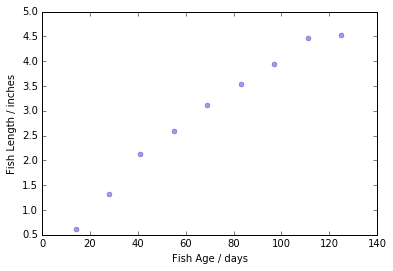

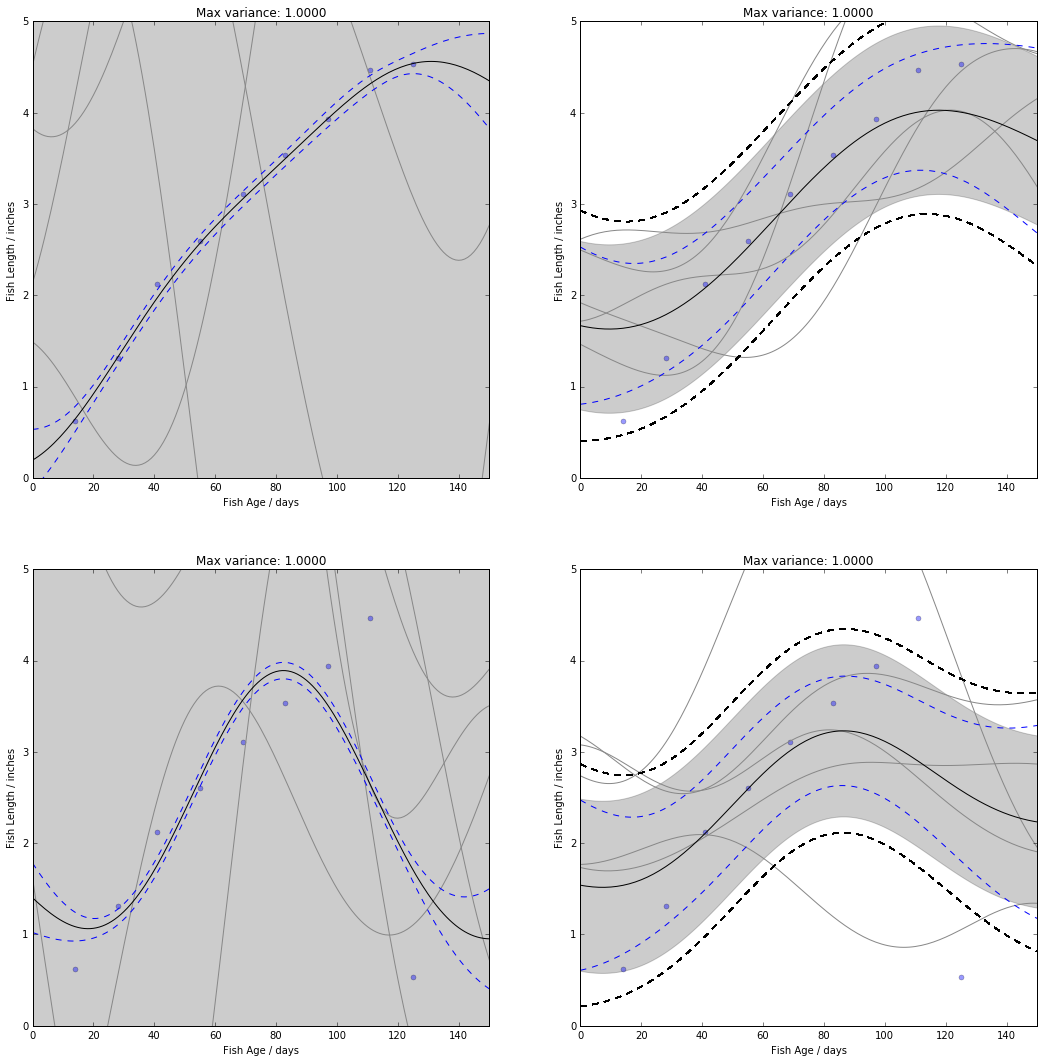

In [33]:
import dp4gp_datasets as datasets
import dp4gp
import GPy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fishdata = datasets.load_fishlength()

X = fishdata[0:9,1] #age of fishes (days)
Y = fishdata[0:9,3] #length of fishes (inches)
#X = X+np.random.randn(X.shape[0])*3.0 #adding some jitter to the dataset for demo purposes
plt.plot(X,Y,'o',alpha=0.4,markersize=5)
plt.xlabel('Fish Age / days')
plt.ylabel('Fish Length / inches')


plotid = 1
plt.figure(figsize=[18,18])
for sigma,normal,tweak in zip([0.1,1.0,0.1,1.0],[False,False,False,False],[0,0,-4,-4]):
    plt.subplot(2,2,plotid)
    plotid+=1
    fishdata = datasets.load_fishlength()

    test_inputs = np.arange(0,360,1)
    #pseudo_inputs = np.array([0,120])
    pseudo_inputs = np.arange(0,160,40)
    lengthscales = 40.0
    #sigma = 0.1*((1+(it * 2.0))) #0.1
    delta = 0.01
    sens = 4.0

    if normal:
        eps = 20
    else:
        eps = 20

    print eps
    X = fishdata[0:9,1] #age of fishes (days)
    Y = fishdata[0:9,3] #length of fishes (inches)
    Y[-1] += tweak
    plt.plot(X,Y,'o',alpha=0.4,markersize=5)

    ymean = np.mean(Y)
    ystd = np.std(Y)
    Y-=ymean
    Y/=ystd

    X = X+np.random.randn(X.shape[0])*3.0 #adding some jitter to the dataset for demo purposes
    plt.xlabel('Fish Age / days')
    plt.ylabel('Fish Length / inches')

    m = GPy.models.GPRegression(X[:,None],Y[:,None]-np.mean(Y))
    m.kern.lengthscale = lengthscales
    m.kern.variance = np.var(Y)
    m.Gaussian_noise = sigma**2

    
    scaletest = {}
    for t in np.hstack([test_inputs,X]):
        scaletest[t] = 1.#/(1+(it * 2.0))
    print scaletest[0]
    test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True,scale=scaletest)
    print "Pseudo (peroutput) max: %0.2f" % np.max(pseudo_peroutput_msense)
    print "Normal (peroutput) max: %0.2f" %  np.max(normal_peroutput_msense)
    print "Pseudo: %0.2f" % pseudo_msense
    print "Normal: %0.2f" % normal_msense

    if normal:
        mu = normal_mu
        msense = normal_msense
    else:
        mu = pseudo_mu
        msense = pseudo_msense
    plotmu=mu*ystd
    plotmu=plotmu+ymean
    for it in range(5):

        preds = dp4gp.draw_sample(test_cov, test_inputs, mu, msense, sens=sens, delta=delta, eps=eps,verbose=(it==0))
        
        
        preds*=ystd
        preds+=ymean

        plt.plot(test_inputs, preds[:,None],'-',color='#888888')
    plt.plot(test_inputs, plotmu[:,None],'-',color='black')
    
    SE = np.sqrt(np.diag(normal_covars)[:,None])
    SE*=ystd
    plt.plot(test_inputs, plotmu[:,None]+SE,'--',color='blue')
    plt.plot(test_inputs, plotmu[:,None]-SE,'--',color='blue')
    
    print "max value of variance of test points: %0.2f" % np.max(np.diag(test_cov))
    test_point_std = np.sqrt(np.diag(test_cov))
    print "mean test point std: %0.4f" % np.mean(test_point_std)
    SE = np.sqrt(np.diag(normal_covars)[:,None]+(test_point_std*msense*sens*np.sqrt(2*np.log(2/delta))/eps)**2)
    SE*=ystd
    plt.plot(test_inputs, plotmu[:,None]+SE,'--',color='black')
    plt.plot(test_inputs, plotmu[:,None]-SE,'--',color='black')
    
    SE = np.sqrt((test_point_std*msense*sens*np.sqrt(2*np.log(2/delta))/eps)**2)
    SE*=ystd
    
    plt.fill(np.hstack([test_inputs,test_inputs[::-1]]),np.hstack([plotmu+SE,(plotmu-SE)[::-1]]),alpha=0.2,color='black')
    #plt.plot(test_inputs, plotmu[:,None]+SE,'--',color='black')
    #plt.plot(test_inputs, plotmu[:,None]-SE,'--',color='black')
    plt.ylim([0,5])
    plt.xlim([0,150])
    plt.title("Max variance: %0.4f" % np.max(test_cov))
    

In [16]:
np.dot(np.array([[0.5,0.5]])/2,np.linalg.inv(np.array([[1,.25],[.25,1]])/2))

array([[ 0.4,  0.4]])

In [21]:
np.max(np.sum(np.linalg.inv(np.array([[1,.25],[.25,1]])/1),0))

0.80000000000000004